In [417]:
from random import random
from math import exp,sqrt
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f(x): 
    if x<0.5: 
        return exp(x)- 0.5**3/3
    return exp(x) + (x-0.5)**2 - 0.5**3/3
    
@njit(fastmath=True)
def trapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        x = xx
    return sol*dx

@njit(fastmath=True)
def MCtrapezium(n,a,b):
    dx = (b-a)/n
    x,sol,solMC,solMC2 = 0,0,0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        l = 10 # russian roulette rate 
        if random()*l<1:
            U = x + random()*(xx-x) # \sim Uniform(x,xx)
            tmp= l*(f(U)-f(x)-(U-x)*(f(xx)-f(x))/dx)
            solMC += tmp
            solMC2 += tmp**2
        x = xx
    return dx*(sol+solMC), sqrt(solMC2-solMC**2)*dx

def exact(a,b): return exp(b)-exp(a) 
MCtrapezium(100,0,1)

(1.7182858739896094, nan)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13036\1201916965.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")


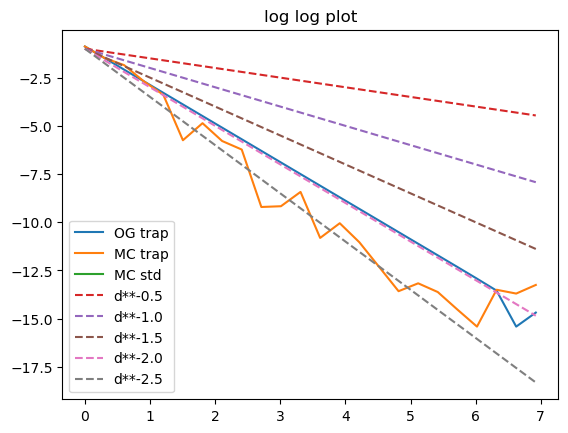

In [418]:

def MCtrap_llplot():
    a,b = 0,1
    DTS = np.power(2,np.array(range(24)))
    errors = np.array([(abs(trapezium(n,a,b)-exact(a,b)))/(exact(a,b)) for n in DTS])
    MCerrors,MCsig = [],[]
    for n in DTS:
        sol,sig = MCtrapezium(n,a,b)
        MCerrors.append((abs(sol-exact(a,b)))/(exact(a,b)))
        MCsig.append(sig)
    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")
    dgs = np.arange(0.5,3,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref/10)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap_llplot()

Ok we need to improve the code the trapezium rule:


In [757]:
from random import random as U
from math import exp
import numpy as np
def f(x): return exp(x)
def trapezium(n): return sum((f(x)+f(x+1/n))/2
    for x in np.arange(0, 1, 1/n))/n
def MCtrapezium(n, l=100):
    sol = 0
    for j in range(n):
        if U()*l < 1:
            x, xx = j/n, (j+1)/n
            S = x + U()*(xx-x)  # \sim Uniform(x,xx)
            sol += l*(f(S)-f(x)-(S-x)*(f(xx)-f(x))*n)/n
    return sol+trapezium(n)
def exact(a, b): return exp(b)-exp(a)
def error(s): return (s-exact(0, 1))/exact(0, 1)
print(f"  error:{error(trapezium(10000))}")
print(f"MCerror:{error(MCtrapezium(10000,100))}")

  error:8.333344745642098e-10
MCerror:8.794793540941216e-11


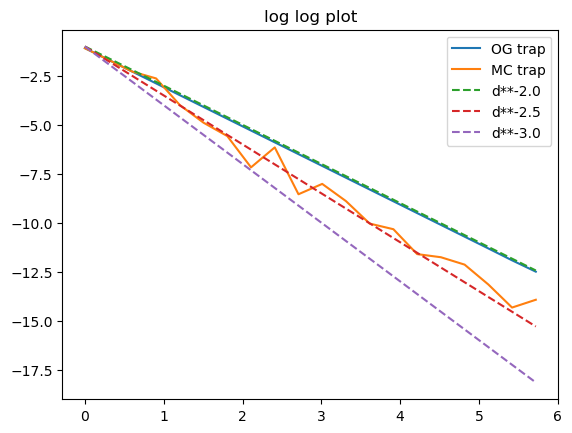

In [663]:
import matplotlib.pyplot as plt
def MCtrap_llplot():
    DTS = np.power(2,np.array(range(20)))
    errors = np.array([(abs(trapezium(n)-exact(0,1)))/(exact(0,1)) for n in DTS])
    MCerrors = np.array([(abs(MCtrapezium(n)-exact(0,1)))/(exact(0,1)) for n in DTS])
    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap")
    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref/10)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap_llplot()

In [747]:
from random import random
from math import exp,cos,sin
from numba import njit, prange
from itertools import product
import numpy as np

@njit(fastmath=True)
def f2(x,y): return cos(x)*cos(y)

@njit(fastmath=True)
def trapezium2(n):
    sol = 0
    for x in np.arange(0,1,1/n):
        for y in np.arange(0,1,1/n):
            sol += (f2(x+1/n,y)+f2(x,y+1/n))/(2*n**2)
    return sol

@njit(fastmath=True)
def MCtrapezium2(n,l=100):
    sol = 0
    for x in np.arange(0,1,1/n):
        for y in np.arange(0,1,1/n):
            if random()*l<1:
                X,Y = x + random()/n, y + random()/n
                control = f2(x,y)+(f2(x+1/n,y)-f2(x,y))*(X-x)*n+(f2(x,y+1/n)-f2(x,y))*(Y-y)*n
                sol += l*(f2(X,Y)-control)/n**2 
    return sol+trapezium2(n)

def exact2(): return (sin(1))**2
def error2(s): return abs(s-exact2())/exact2()

print(error2(trapezium2(10)))
print(error2(MCtrapezium2(10)))

0.00241236586062192
0.00241236586062192


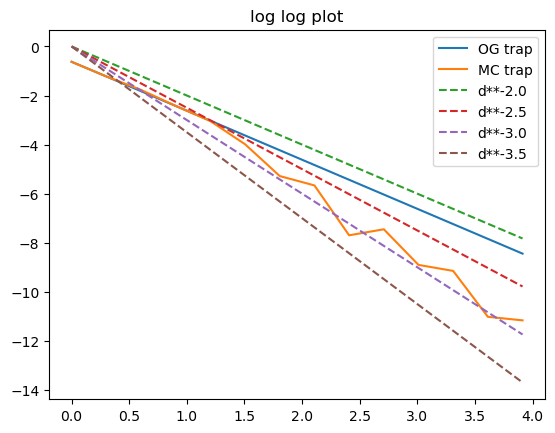

In [751]:
import matplotlib.pyplot as plt
def MCtrap2_llplot():
    DTS = np.power(2,np.array(range(14)))
    errors = np.array([error2(trapezium2(n)) for n in DTS])
    MCerrors = np.array([error2(MCtrapezium2(n)) for n in DTS])
    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap")
    dgs = np.arange(2,4,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap2_llplot()